# Initialization

Notebook for the C-MAPPS benchmark. Plot the real vs the predicted RUL 

First we import the necessary packages and create the global variables.

In [1]:
import math
import numpy as np
import csv
import copy
import sys

from scipy import stats
from sklearn.preprocessing import StandardScaler, MinMaxScaler

sys.path.append('/Users/davidlaredorazo/Documents/University_of_California/Research/Projects')

from ann_framework.data_handlers.data_handler_CMAPSS import CMAPSSDataHandler
from ann_framework.tunable_model.tunable_model import SequenceTunableModelRegression
from ann_framework import aux_functions

import CMAPSSPlot_AuxFunctions

from keras.models import model_from_json, clone_model
from keras import regularizers
from keras.models import Sequential, Model
from keras.layers import Dense, Input, Dropout, Reshape, Conv2D, Flatten, MaxPooling2D
from keras.optimizers import Adam
from keras.callbacks import LearningRateScheduler
from keras import backend as K

import matplotlib.pyplot as plt
from matplotlib import rcParams

import seaborn as sns; sns.set(font_scale=1.2)

%matplotlib inline

Using TensorFlow backend.


# Function to plot RULs

In [2]:
def plot_RUL(real_rul_list, predicted_rul_list):
    
    for real_rul, predicted_rul, i in zip(real_rul_list, predicted_rul_list, range(len(real_rul_list))):
        
        x = np.arange(1,real_rul.shape[0]+1)
        e = real_rul-predicted_rul
        
        plt.clf()
        fig = plt.figure(i)
        fig.suptitle('Real RUL vs Predicted RUL for FD00'+str(i+1), fontsize=14)
        #plt.title('Real RUL vs Predicted RUL')
        
        plt.subplot(2,1,1)
        plt.xlabel("Engine Number")
        plt.ylabel("RUL")
        plt.plot(x, predicted_rul, 'r--')
        plt.plot(x, real_rul, 'g--')
        plt.legend(('Predicted RUL', 'Real RUL'), loc='center left', bbox_to_anchor=(1, 0.5))
        
        y_ticks_array = gen_yticks(e)
        
        plt.subplot(2,1,2)
        plt.xlabel("Engine Number")
        plt.ylabel("$E_{RMS}$")
        plt.plot(x, e, 'm--')
        plt.yticks(y_ticks_array)
        
        #plt.show()
        plt.savefig('rul_plots_dataset_'+str(i+1)+'.pdf', format='pdf', bbox_inches='tight', dpi=300)
        #plt.savefig('rul_plots_dataset_'+str(i+1)+'.png', dpi=900, format='png', bbox_inches='tight')

In [3]:
def gen_yticks(error_array):
    
    min_val = np.amin(error_array)
    max_val = np.amax(error_array)
    min_val_yticks_multiplier = math.floor(min_val/25)
    max_val_yticks_multiplier =  math.ceil(max_val/25)
    min_val_yticks = 25*min_val_yticks_multiplier
    max_val_yticks = 25*max_val_yticks_multiplier
        
    y_ticks_array = np.arange(min_val_yticks, max_val_yticks+25, 25)
    
    if y_ticks_array.size > 6:
        min_val_yticks_multiplier = math.floor(min_val/50)
        max_val_yticks_multiplier =  math.ceil(max_val/50)
        min_val_yticks = 50*min_val_yticks_multiplier
        max_val_yticks = 50*max_val_yticks_multiplier
        
        y_ticks_array = np.arange(min_val_yticks, max_val_yticks+50, 50)
        
    return y_ticks_array

In [4]:
def gen_stats(real_rul_list, predicted_rul_list):
    
    list_e_real = []
    list_e_abs = []
    
    for real_rul, predicted_rul, i in zip(real_rul_list, predicted_rul_list, range(len(real_rul_list))):
        
        e = real_rul-predicted_rul
        e_abs = np.absolute(e)
        e_abs.sort()
        
        first_percentile = np.percentile(e_abs, 25, interpolation='lower')
        second_percentile = np.percentile(e_abs, 50, interpolation='lower')
        third_percentile = np.percentile(e_abs, 75, interpolation='lower')
        
    
        """
        print("For FD001"+str(i+1))
        #print(e)
        #print(e_abs)
        print(stats.describe(e))
        print(stats.describe(e_abs))
        print(first_percentile)
        print(second_percentile)
        print(third_percentile)
        """
        
        list_e_real.append(e)
        list_e_abs.append(e_abs)
        
    return list_e_real, list_e_abs

# Create data Handler

In [5]:
#Selected as per CNN paper
features = ['T2', 'T24', 'T30', 'T50', 'P2', 'P15', 'P30', 'Nf', 'Nc', 'epr', 'Ps30', 'phi', 'NRf', 'NRc', 
                     'BPR', 'farB', 'htBleed', 'Nf_dmd', 'PCNfR_dmd', 'W31', 'W32']
selected_indices = np.array([2, 3, 4, 7, 8, 9, 11, 12, 13, 14, 15, 17, 20, 21])
selected_features = list(features[i] for i in selected_indices-1)
data_folder = '../CMAPSSData'

window_size = 30
window_stride = 1
max_rul = 125

dHandler_cmaps = CMAPSSDataHandler(data_folder, 1, selected_features, max_rul, window_size, window_stride)
#dHandler_cmaps.load_data(verbose=1, cross_validation_ratio=0.2)

# Load models and get predicted and real RULs

In [6]:
datasets = [1, 2, 3, 4]

window_sizes = {1:24,2:17,3:24,4:17}
strides = {1:1,2:1,3:1,4:1}
max_ruls = {1:129, 2:139, 3:129, 4:139}

y_predicted_list = []
y_true_list = []


for i in datasets:

    # load json and create model
    json_file = open('models/bestRULModel_dataset_'+str(i)+'.json', 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    loaded_model = model_from_json(loaded_model_json)
    # load weights into new model
    loaded_model.load_weights("models/bestRULModel_dataset_"+str(i)+".h5")
    print("Loaded model from disk")


    #Shared parameters for the models
    optimizer = Adam(lr=0, beta_1=0.5)
    lossFunction = "mean_squared_error"
    metrics = ["mse"]

    #Selected as per CNN paper
    selected_features = ['T24', 'T30', 'T50', 'P30', 'Nf', 'Nc', 'Ps30', 'phi', 'NRf', 'NRc', 
                         'BPR', 'htBleed', 'W31', 'W32']

    #Create and compile the models
    #nFeatures = len(selected_features)
    #shapeSN = nFeatures*windowSize
    #modelRULSN = RULmodel_SN_1(shapeSN)
    loaded_model.compile(optimizer = optimizer, loss = lossFunction, metrics = metrics)

    #min_max_scaler = MinMaxScaler(feature_range=(-1, 1))
    min_max_scaler = MinMaxScaler()

    tModel = SequenceTunableModelRegression('ModelRUL_SN_1', loaded_model, lib_type='keras', data_handler=dHandler_cmaps)

    tModel.data_handler.change_dataset(i)
    tModel.data_handler.sequence_length = window_sizes[i]
    tModel.data_handler.sequence_stride = strides[i]
    tModel.data_handler.max_rul = max_ruls[i]

    tModel.data_handler.data_scaler = None
    tModel.data_scaler = min_max_scaler

    tModel.load_data(unroll=True, verbose=1, cross_validation_ratio=0)
    #tModel.print_data()
    #print(tModel.model.get_weights())
    tModel.get_model_description()
    
    # evaluate loaded model on test data
    tModel.evaluate_model(['rhs', 'rmse'], round=2)
    print("scores")

    #print(tModel.y_pred)

    cScores = tModel.scores
    print(cScores)
    rmse = math.sqrt(cScores['score_1'])
    rmse2 = cScores['rmse']
    rhs = cScores['rhs']
    time = tModel.train_time
    
    y_predicted = tModel.y_predicted_rounded.flatten()
    y_true = tModel.y_test.flatten()
    
    y_predicted_list.append(y_predicted)
    y_true_list.append(y_true)

    print(cScores)
    print("RMSE: {}".format(rmse))
    print("RMSE2: {}".format(rmse2))
    print("RHS: {}".format(rhs))
    print("Time : {} seconds".format(time))

Loaded model from disk
Loading data for the first time
Reloading data due to parameter change
Loading data for dataset 1 with window_size of 24, stride of 1 and maxRUL of 129. Cros-Validation ratio 0
Loading data from file and computing dataframes
Description for model: ModelRUL_SN_1
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
fc1 (Dense)                  (None, 20)                6740      
_________________________________________________________________
fc2 (Dense)                  (None, 20)                420       
_________________________________________________________________
out (Dense)                  (None, 1)                 21        
Total params: 7,181
Trainable params: 7,181
Non-trainable params: 0
_________________________________________________________________
100/100 [==============================] - 0s 2ms/step
scores
{'loss': 270.6421148681641, 'score_1': 206.36583923339845

## Plot real vs predicted RULs

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

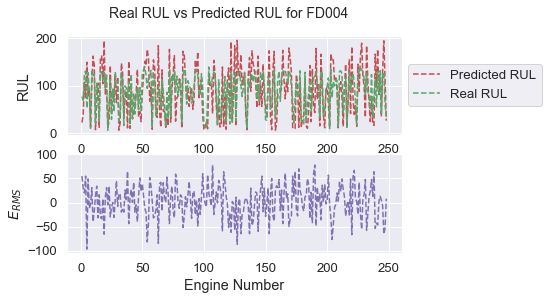

In [7]:
plot_RUL(y_predicted_list, y_true_list)

## Boxplot error statistics

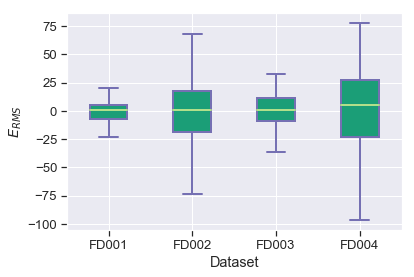

In [8]:
list_e_real, list_e_abs = gen_stats(y_predicted_list, y_true_list)

# Create a figure instance
fig = plt.figure()

# Create an axes instance
ax = fig.add_subplot(111)

## add patch_artist=True option to ax.boxplot() 
## to get fill color
bp = ax.boxplot(list_e_real, patch_artist=True, showfliers=False)

## change outline color, fill color and linewidth of the boxes
for box in bp['boxes']:
    # change outline color
    box.set( color='#7570b3', linewidth=2)
    # change fill color
    box.set( facecolor = '#1b9e77' )

    ## change color and linewidth of the whiskers
    for whisker in bp['whiskers']:
        whisker.set(color='#7570b3', linewidth=2)

    ## change color and linewidth of the caps
    for cap in bp['caps']:
        cap.set(color='#7570b3', linewidth=2)

    ## change color and linewidth of the medians
    for median in bp['medians']:
        median.set(color='#b2df8a', linewidth=2)

    ## change the style of fliers and their fill
    for flier in bp['fliers']:
        flier.set(marker='o', color='#e7298a', alpha=0.5)


## Custom x-axis labels
ax.set_xticklabels(['FD001', 'FD002', 'FD003', 'FD004'])

## Remove top axes and right axes ticks
ax.get_xaxis().tick_bottom()
ax.get_yaxis().tick_left()

plt.xlabel("Dataset")
plt.ylabel("$E_{RMS}$")
        
# Save the figure
fig.savefig('error_stats_boxplot.pdf', format='pdf', bbox_inches='tight', dpi=300)
#fig.savefig('error_stats_boxplot.png', bbox_inches='tight', dpi=900)
#plt.show()


# Create plot for illustrating the data reshape

In [ ]:
def plot_windows(plotting_data):
    
    plt.clf()
    
    x = range(0, plotting_data.shape[0])
    
    for i in range(plotting_data.shape[1]):
        
        y = plotting_data[:,i]
        y = y+i
        plt.plot(x, y)
        
    plt.plot([0,0], [0,14], linestyle='-.', color='k')
    plt.plot([5,5], [0,14], linestyle='-.', color='k')
    
    plt.plot([4,4], [0,14], linestyle='-.', color='r')
    plt.plot([9,9], [0,14], linestyle='-.', color='r')
        
    plt.ylabel("Sensor number")
    plt.xlabel("Engine cycle")
    plt.title("Window and stride")
    #plt.show()
    plt.savefig('window_stride.pdf', format='pdf', bbox_inches='tight', dpi=300)
    #plt.savefig('window_stride.png', dpi=900, format='png', bbox_inches='tight')

In [ ]:
#Selected as per CNN paper
features = ['T2', 'T24', 'T30', 'T50', 'P2', 'P15', 'P30', 'Nf', 'Nc', 'epr', 'Ps30', 'phi', 'NRf', 'NRc', 
                     'BPR', 'farB', 'htBleed', 'Nf_dmd', 'PCNfR_dmd', 'W31', 'W32']
selected_indices = np.array([2, 3, 4, 7, 8, 9, 11, 12, 13, 14, 15, 17, 20, 21])
selected_features = list(features[i] for i in selected_indices-1)
data_folder = '../CMAPSSData'

window_size = 30
window_stride = 1
max_rul = 125

min_max_scaler = MinMaxScaler()

dHandler_cmaps2 = CMAPSSDataHandler(data_folder, 1, selected_features, max_rul, window_size, window_stride)
dHandler_cmaps2.data_scaler = MinMaxScaler()
dHandler_cmaps2.load_data(verbose=1, unroll=False)
#dHandler_cmaps2.print_data()
#dHandler_cmaps.load_data(verbose=1, cross_validation_ratio=0.2)

In [ ]:
plotting_data = dHandler_cmaps2.X_train[0]
plot_windows(plotting_data)

In [ ]:
#Plot ReLu and Linear

x = np.linspace(-10,10, 100)
relu = x*(x>0)

plt.clf()
plt.plot(x, x, color='b')
plt.ylabel("linear(x)")
plt.xlabel("x")
plt.title("Linear activation function")
plt.savefig('linear_function.png', dpi=900, format='png', bbox_inches='tight')

plt.clf()
plt.plot(x, relu, color='b')
plt.ylabel("relu(x)")
plt.xlabel("x")
plt.title("ReLU activation function")
plt.savefig('relu_function.png', dpi=900, format='png', bbox_inches='tight')

# Plot boxplots for error statistics

In [ ]:
#Load the results data

data = np.genfromtxt('results/MLP/resultsDatasets_all_sn20_20.csv', delimiter=',')
#print(data)

for i in range(4):
    tempScoresRMSE = data[i*3+0]
    tempScoresRHS = data[i*3+1]
    tempTime = data[i*3+2]
    
    print(stats.describe(tempScoresRMSE))
    print(stats.describe(tempScoresRHS))
    print(stats.describe(tempTime))

## Create boxplots

For each of the datasets create boxplots using their statistics and compare them using each metric

In [ ]:
data = np.genfromtxt('results/MLP/resultsDatasets_all_sn20_20.csv', delimiter=',')

data_rmse = [] 
data_rhs = []

print(data[0])

rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Times New Roman']
rcParams['font.size'] = 18
rcParams['figure.dpi'] = 300

for dataset in range(4):
    
    #data_rmse.append([data[dataset*3], data[dataset*3+12], data[dataset*3+24]]) 
    #data_rhs.append([data[dataset*3+1], data[dataset*3+13], data[dataset*3+25]])
    
    data_rmse.append([data[dataset*3], data[dataset*3+12]]) 
    data_rhs.append([data[dataset*3+1], data[dataset*3+13]])
    
    #data_rmse.append([data[dataset*3]]) 
    #data_rhs.append([data[dataset*3+1]])


f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4)
#f.suptitle('Different sets of data-related parameters')
plt_ax = [ax1, ax2, ax3, ax4]
count = 0

for data_plot in data_rmse:
    medianprops = dict(linestyle='-', linewidth=1, color='red')
    plt_ax[count].boxplot(data_plot, showfliers=False, medianprops=medianprops)
    plt_ax[count].set_facecolor('white')
    plt_ax[count].yaxis.grid(which="major", color='0.75', linestyle='-', linewidth=0.5)
    plt.sca(plt_ax[count])
    locs, _ = plt.xticks()
    plt.xticks(locs, ['2 sets', '1 set'], rotation=60)
    if count == 0:
        plt_ax[count].set_ylabel('RMSE')
        
    plt_ax[count].set_title('FD00'+str(count+1))
    count = count + 1 

f.tight_layout()
plt.savefig('rmse_comparisson.svg', bbox_inches='tight', format='svg')
plt.savefig('rmse_comparisson.png', bbox_inches='tight', dpi=300)

plt.clf()
f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4)
#f.suptitle('Different sets of data-related parameters')
plt_ax = [ax1, ax2, ax3, ax4]

count = 0
for data_plot in data_rhs:
    medianprops = dict(linestyle='-', linewidth=1, color='red')
    plt_ax[count].boxplot(data_plot, showfliers=False, medianprops=medianprops)
    plt_ax[count].set_facecolor('white')
    plt_ax[count].yaxis.grid(which="major", color='0.75', linestyle='-', linewidth=0.5)
    plt.sca(plt_ax[count])
    locs, _ = plt.xticks()
    plt.xticks(locs, ['2 sets', '1 set'], rotation=60)
    if count == 0:
        plt_ax[count].set_ylabel('RHS')
        
    plt_ax[count].set_title('FD00'+str(count+1))
    count = count + 1 

f.tight_layout()

plt.savefig('rul_plots_dataset_'+str(i+1)+'.pdf', format='pdf', bbox_inches='tight', dpi=300)
plt.savefig('rhs_comparisson.svg', bbox_inches='tight', format='svg')
plt.savefig('rhs_comparisson.png', bbox_inches='tight', dpi=300)


# Plot example for piecewise linear degradation model

In [ ]:
def plot_linear_degradation_model(cycles, rulArray, engineUnit):
    
    rcParams['font.family'] = 'sans-serif'
    rcParams['font.sans-serif'] = ['Times New Roman']
    rcParams['font.size'] = 18
    rcParams['figure.dpi'] = 300
    
    plt.clf()
    ax = plt.gca()
    ax.yaxis.grid(which="major", color='0.75', linestyle='-', linewidth=0.5)
    ax.set_facecolor('white')
    plt.plot(cycles, rulArray, 'b.-', label='RUL')
    plt.xlabel("Time (Cycle)")
    plt.ylabel("RUL")
    plt.title("Test Engine Unit #{}".format(engineUnit))
    
    plt.savefig('test_engine.pdf', format='pdf', bbox_inches='tight', dpi=300)
    
    #plt.savefig('test_engine.svg', bbox_inches='tight', format='svg')
    #plt.savefig('test_engine.png', bbox_inches='tight', dpi=300)
    
    plt.show()
    
def plot_piecewise_by_engine(data_handler, engineUnit):

    time_window = data_handler.sequence_length
    constRUL = data_handler.max_rul
    stride = data_handler.sequence_stride
    
    df_engine = data_handler.df_train
    df_engine = df_engine.loc[df_engine['Unit Number'] == engineUnit, :]
    df_engine['Unit Number'] = 1
    
    X_test2, _, _, _, _ = CMAPSSPlot_AuxFunctions.create_windowed_data(df_engine, selected_features, 'train', 
                         time_window=time_window, constRUL=constRUL, stride=stride, 
                         crossValidationRatio=0)
    
    maxCycle = X_test2.shape[0]
    faultCycle = data_handler.y_test[engineUnit-1]
    cycles = np.arange(maxCycle)
    rulArray = np.arange(faultCycle, maxCycle+faultCycle)
    rulArray[rulArray > constRUL] = constRUL
    rulArray = np.flipud(rulArray)
    
    plot_linear_degradation_model(cycles, rulArray, engineUnit)
    #plt.plot(cycles, nnPred, 'go-', label='NN Pred')
    #plt.legend()

In [ ]:
plot_piecewise_by_engine(dHandler_cmaps2, 21)